In [1]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from utils.mlflow_query import MlflowHelper

In [3]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), 
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="831333387297563441")
mlflow_helper.query_runs(pkl_file=Path("mlflow_run_df.pkl"))

Querying data per run...: 100%|██████████| 154/154 [00:03<00:00, 47.97it/s]


In [4]:
def plot_metrics_over_epochs(metric_df, metric_names, 
    column_feature_name='data_tags_model_type', 
    row_feature_name='data_tags_sequence_type',
    hue_feature_name='data_params_ModelConfighidden_embedding_initializer',
    style_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    titles="{row_name}, {col_name}",
):
    for metric_name in metric_names:
        g = sns.relplot(
            data=metric_df, x="epoch", y=metric_name,
            col=column_feature_name, row=row_feature_name, 
            hue=hue_feature_name, style=style_feature_name, 
            units='info_run_id', estimator=None,
            kind="line", facet_kws={'sharey':False},
        )
        g.set_titles(titles)
        g.savefig("epochs_{}.png".format(metric_name))

def plot_best_metric_strip(metric_df, metric_names, feature_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic',], #'causal_score'],
    row_feature_name='data_tags_sequence_type',
    hue_feature_name='data_params_ModelConfighidden_embedding_initializer',
    column_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    titles="{row_name}, Trainable: {col_name}",
):
    grouped_df = metric_df.groupby(feature_names, as_index=False).agg({
        metric_name:max for metric_name in metric_names
    })
    for metric_name in metric_names:
        g = sns.catplot(
            data=grouped_df, y=metric_name, 
            x=x_feature_name, order=x_order, row=row_feature_name, 
            hue=hue_feature_name, col=column_feature_name,
            kind="strip", sharey='row',
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)

        g.savefig("strip_{}.png".format(metric_name))

def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic', 'causal_score'],
    row_feature_name='data_tags_sequence_type',
    hue_feature_name='data_params_ModelConfighidden_embedding_initializer',
    col_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    titles="{row_name}, Trainable: {col_name}",
    palette=None,
    dodge=True,
    col_order=None,
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge,
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        g.savefig("bar_{}.png".format(metric_name))


Querying metrics for runs: 100%|██████████| 150/150 [00:10<00:00, 14.67it/s]


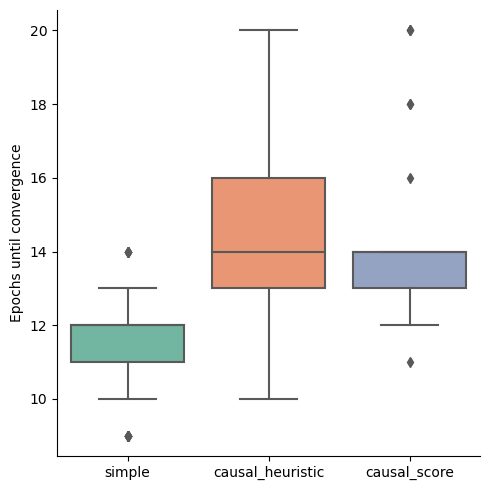

In [5]:
df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False, include_drain_hierarchy=True)
df = mlflow_helper.load_best_metrics_for_ids(set(df["info_run_id"]))
g = sns.catplot(
    data=df, 
    x="data_tags_model_type",
    y='epoch', 
    order=["simple", "causal_heuristic", "causal_score"],
    #col="data_params_ModelConfigbase_hidden_embeddings_trainable",
    #col_order=["False", "True"],
    kind="box", 
    palette='Set2', 
    #color="#19b39c",
    #dodge=False,
).set_axis_labels('', "Epochs until convergence")#.set_titles("Embeddings trainable: {col_name}")
plt.tight_layout()
# plt.savefig("huawei_epochs_nontrainable.png", dpi=100)
plt.show()

Querying metrics for runs: 100%|██████████| 150/150 [00:10<00:00, 14.50it/s]


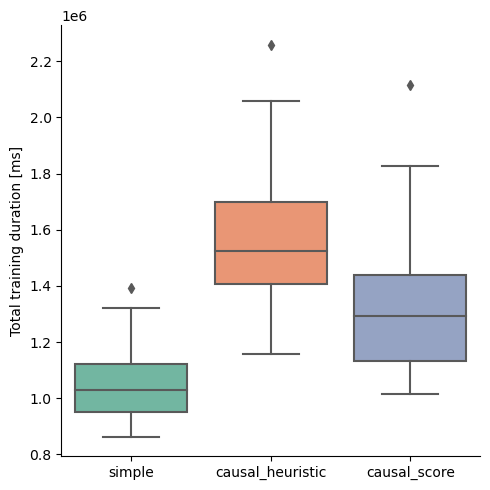

In [6]:
df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False, include_drain_hierarchy=True)
df = mlflow_helper.load_training_times_for_ids(set(df["info_run_id"]))
g = sns.catplot(
    data=df
    , x="data_tags_model_type",
    y='total_duration', 
    order=["simple", "causal_heuristic", "causal_score"],
    #col_order=["False", "True"],
    kind="box", 
    palette='Set2', 
    #color="#19b39c",
    #dodge=False,
).set_axis_labels('', "Total training duration [ms]")#.set_titles("Embeddings trainable: {col_name}")
plt.tight_layout()
plt.savefig("huawei_total_duration_nontrainable.png", dpi=100)
plt.show()

In [7]:
df["avg_per_epoch_conv"] = df["avg_per_epoch"] / (1000)
df.groupby(by="data_tags_model_type")["avg_per_epoch_conv"].describe()

,count,mean,std,min,25%,50%,75%,max
data_tags_model_type,,,,,,,,
causal_heuristic,50.0,71.342282,7.451996,60.331150,64.831433,71.412905,74.425566,85.784619
causal_score,50.0,62.990806,8.595177,53.399619,53.923066,62.779735,67.707248,80.256905
simple,50.0,56.741394,5.270387,47.965944,53.708163,56.488007,59.357892,69.541650


Querying metrics for runs: 100%|██████████| 150/150 [00:10<00:00, 14.54it/s]


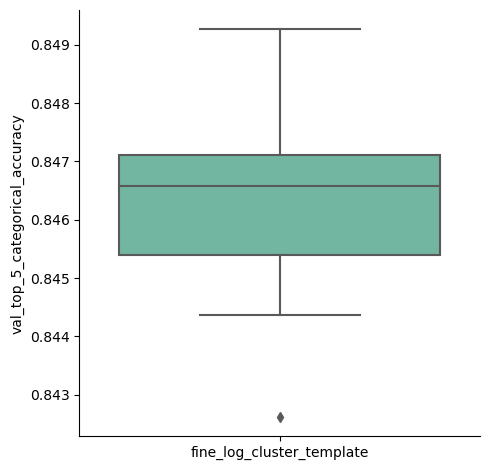

In [8]:
df = mlflow_helper.huawei_run_df(
    include_noise=False, 
    include_refinements=False, 
    risk_prediction=False,
    include_drain_hierarchy=True,
    valid_x_columns=["fine_log_cluster_template", "coarse_log_cluster_template"])

df = mlflow_helper.load_best_metrics_for_ids(set(df["info_run_id"]))
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "log_cluster_template": "fine_log_cluster_template",
}.get(x, x))
df["baseline"] = df["data_tags_model_type"] == "simple"

g = sns.catplot(
    data=df[
        df["data_tags_model_type"].apply(lambda x: x == "simple")
    ], x="data_params_SequenceConfigx_sequence_column_name", y='val_top_5_categorical_accuracy_history_best', 
    order=["fine_log_cluster_template"],
    # order=["fine_log_cluster_template", "coarse_log_cluster_template"],
    kind="box", palette='Set2',
    dodge=False,
).set_axis_labels('', "val_top_5_categorical_accuracy")
plt.show()

In [9]:
huawei_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False)
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 150/150 [00:10<00:00, 14.68it/s]


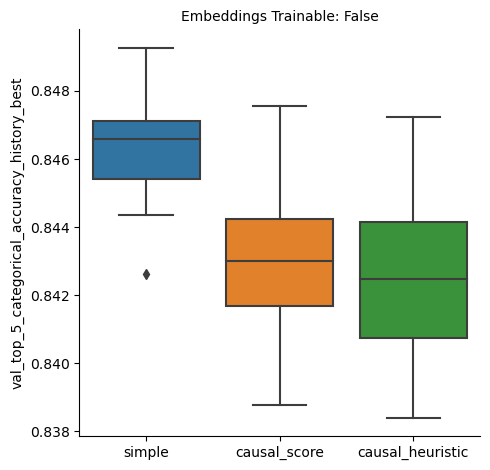

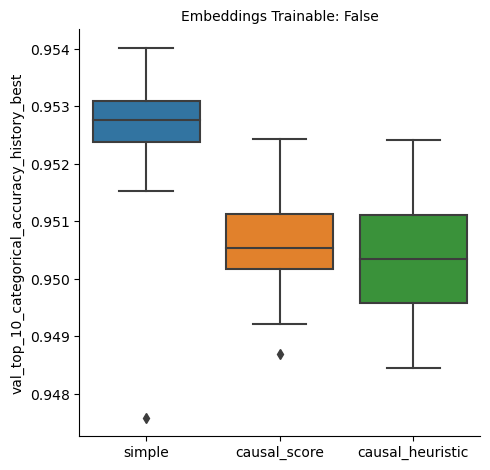

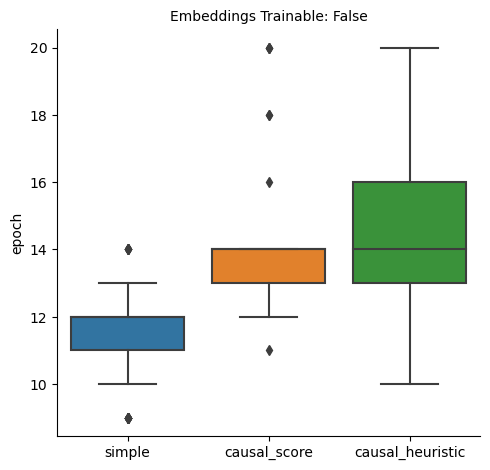

In [10]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best', 'epoch'], 
    hue_feature_name=None, 
    col_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    row_feature_name=None,
    x_order=["simple", "causal_score", "causal_heuristic"],
    titles="Embeddings Trainable: {col_name}")
plt.show()

In [11]:
huawei_df = mlflow_helper.huawei_run_df(
    include_noise=False, include_refinements=False, risk_prediction=False, include_drain_hierarchy=True,
    valid_x_columns=["log_cluster_template", "fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template_90"])
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 150/150 [00:10<00:00, 14.45it/s]


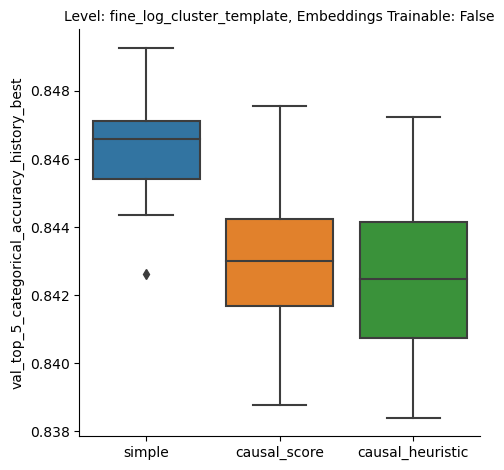

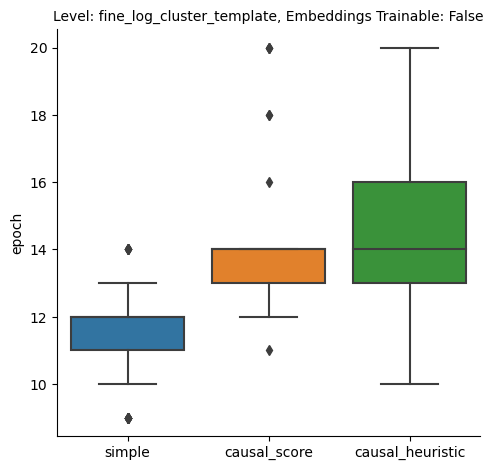

In [19]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best', 'epoch'], 
    hue_feature_name=None, 
    col_feature_name='data_params_SequenceConfigx_sequence_column_name',
    row_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    col_order=["fine_log_cluster_template"],
    x_order=["simple", "causal_score", "causal_heuristic"],
    titles="Level: {col_name}, Embeddings Trainable: {row_name}")
plt.show()

In [13]:
huawei_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False)
huawei_df = mlflow_helper.load_metric_history_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 150/150 [00:10<00:00, 14.42it/s]


In [14]:
huawei_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False)
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 150/150 [00:10<00:00, 14.80it/s]


In [15]:
prediction_df = pd.read_csv(mlflow_helper.local_mlflow_dir + str(huawei_df["info_run_id"].iloc[0]) + "/artifacts/prediction_output.csv")
prediction_df

,input,output,predictions
0,{0: ['fine_log_cluster_template#instance * too...,"['http_method#get', 'programname#keystone-apac...",{'python_module#neutron.plugins.ml2.drivers.op...
1,{0: ['fine_log_cluster_template#instance * del...,"['http_status#204.0', 'programname#placement-a...",{'python_module#neutron.plugins.ml2.drivers.op...
2,{0: ['fine_log_cluster_template#instance * del...,"['http_method#get', 'programname#placement-api...",{'python_module#neutron.plugins.ml2.drivers.op...
3,{0: ['fine_log_cluster_template#instance * too...,"['Hostname#wally124', 'log_level#info', 'pytho...",{'python_module#neutron.plugins.ml2.drivers.op...
4,{0: ['fine_log_cluster_template#instance * dur...,"['python_module#nova.api.openstack.wsgi', 'Hos...",{'python_module#neutron.plugins.ml2.drivers.op...
...,...,...,...
13973,{0: ['fine_log_cluster_template#get v20 networ...,"['http_method#get', 'programname#placement-api...",{'python_module#neutron.plugins.ml2.drivers.op...
13974,{0: ['fine_log_cluster_template#get resource p...,"['http_method#get', 'programname#placement-api...",{'python_module#neutron.plugins.ml2.drivers.op...
13975,{0: ['fine_log_cluster_template#get resource p...,"['http_method#get', 'programname#placement-api...",{'python_module#neutron.plugins.ml2.drivers.op...
13976,{0: ['fine_log_cluster_template#image 5ddb8ba7...,"['http_method#get', 'programname#placement-api...",{'python_module#neutron.plugins.ml2.drivers.op...


In [16]:
prediction_df['input'].apply(lambda x: 1 if "exception" in x.lower() else 0).sum()

719

In [17]:
huawei_df[['epoch', 'data_tags_model_type']]

,epoch,data_tags_model_type
0,14,causal_score
1,11,simple
2,14,causal_heuristic
3,9,simple
4,12,simple
...,...,...
145,12,causal_heuristic
146,11,simple
147,12,simple
148,20,causal_heuristic


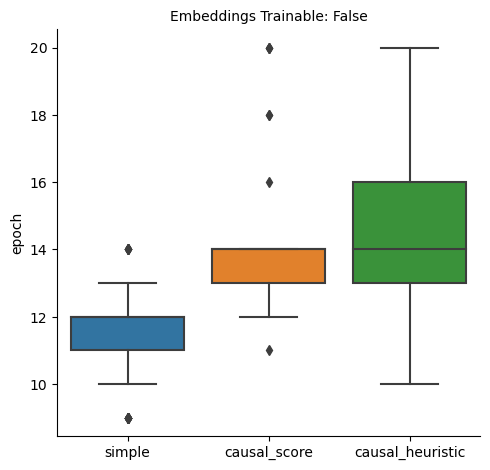

In [18]:
plot_best_metric_bar(huawei_df, ['epoch'], 
    hue_feature_name=None, 
    col_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    row_feature_name=None,
    x_order=["simple", "causal_score", "causal_heuristic"],
    titles="Embeddings Trainable: {col_name}")
plt.show()

# NOISE

In [ ]:
mimic_noise_df = mlflow_helper.mimic_run_df(include_noise=True)
mimic_noise_df = mlflow_helper.load_best_metrics_for_ids(set(mimic_noise_df["info_run_id"]))
mimic_noise_df['data_tags_noise_type'] = mimic_noise_df['data_tags_noise_type'].fillna('').astype(str).apply(lambda x: x + '_threshold0.0' if len(str(x)) <= len('added0.0_removed0.1') and len(x) > 0 else x)
mimic_noise_df['data_tags_noise_type'] = mimic_noise_df['data_tags_noise_type'].apply(lambda x: 'no_noise' if len(x) == 0  or x == 'nan' else x)

In [ ]:
mimic_noise_df = mimic_noise_df[mimic_noise_df['data_tags_model_type'].apply(lambda x: x in ['hierarchy', 'gram', 'causal', 'text'])].copy().reset_index(drop=True)
mimic_noise_df = mimic_noise_df[mimic_noise_df['data_tags_noise_type'].str.endswith('_threshold0.0') | mimic_noise_df['data_tags_noise_type'].str.endswith('no_noise')].copy().reset_index(drop=True)
mimic_noise_df['noise'] = mimic_noise_df['data_tags_noise_type'].apply(
    lambda x: float(x[len('added'):len('added0.0')]) - float(x[len('added0.0_removed'):len('added0.0_removed0.0')]) if not (x == 'no_noise') else 0.0
)
mimic_noise_df['Knowledge Graph'] = mimic_noise_df['noise'].apply(lambda x: 'Original' if x == 0.0 else 'Noisy')
mimic_noise_df["Domain Knowledge"] = mimic_noise_df["data_tags_model_type"].apply(lambda x: {
    "gram": "hierarchy",
}.get(x, x))

g = sns.catplot(
    data=mimic_noise_df[
        mimic_noise_df["data_params_ModelConfigbase_hidden_embeddings_trainable"] == "False"
    ], x="noise", y='val_top_20_categorical_accuracy_history_best', 
    col="Domain Knowledge",
    col_order=["hierarchy", "causal", "text"],
    kind="box", palette='Set2',
    hue="Knowledge Graph", dodge=False,
    hue_order=["Noisy", "Original"],
).set_axis_labels('Degree of Noise', "val_top_20_categorical_accuracy").set_titles("Domain Knowledge: {col_name}")

#plt.tight_layout()
plt.savefig("noise.png", dpi=100, bbox_inches="tight")
plt.show()